# Step 1: Import required modules 

In [1]:
%%capture
!pip3 install tensorflow_text

In [2]:
import tensorflow_text as text

2023-01-14 09:57:44.892925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 09:57:44.996889: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-14 09:57:45.000676: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 09:57:45.000693: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Read data

In [4]:
data=pd.read_json('/work/Sarcasm_Headlines_Dataset_v2.json',lines=True)

In [5]:
data

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [6]:
data.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [7]:
word_len=[]
for i in range(len(data)):
    word_len.append(len(data.headline[i].split(' ')))
print("Max word length of the headlines:",max(word_len))
print("average word length of the headlines:",round(np.mean(word_len)))

Max word length of the headlines: 151
average word length of the headlines: 10


# Step 3: Prepare dataset and preprocessing

In [8]:
#splitting into 4:1 ratio

X_train, X_test, Y_train, Y_test= train_test_split(data.headline,data.is_sarcastic,test_size=0.2,
                                                  random_state=1729)

In [9]:
#import BERT preprocessor and encoder from Tensorflow Hub

#using a 4 layered small-bert with H=768

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/2")

2023-01-14 09:57:48.304917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-14 09:57:48.304945: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-14 09:57:48.304974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-5f83980f-250b-49be-9c90-886a2cee39ce): /proc/driver/nvidia/version does not exist
2023-01-14 09:57:48.305126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#we use pooled outputs to get the tokenized keys
#example

def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

example=[data.headline.values[100],
         data.headline.values[200],
        data.headline.values[300],
        data.headline.values[400],
        data.headline.values[500]]

print("Sentence embedding's shape for 1 sentence:",get_sentence_embeding(example)[0].shape)
print("Sentence embeddings of the string list 'example':",get_sentence_embeding(example))

Sentence embedding's shape for 1 sentence: (768,)
Sentence embeddings of the string list 'example': tf.Tensor(
[[ 0.997378    0.41345966 -0.5065374  ...  0.41472173  0.94609636
   0.07483301]
 [ 0.9508624   0.10688436 -0.15635188 ...  0.29659393  0.96356505
   0.13068047]
 [ 0.9930266   0.30742428  0.22018501 ... -0.26274404  0.7711808
   0.24413653]
 [ 0.9957143  -0.40828353 -0.1603819  ... -0.10841624  0.8482477
  -0.19322284]
 [ 0.69020045 -0.00567232 -0.27240774 ... -0.33065003  0.99611294
   0.41893882]], shape=(5, 768), dtype=float32)


# Step 4: Create a fine-tuned BERT model

In [11]:
# BERT model layers


text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
X=outputs['pooled_output']

# Custom layers and fine-tuning

nn= tf.keras.layers.Dense(128,activation='relu')(X)
nn = tf.keras.layers.Dropout(0.3, name="dropout")(nn)
nn = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(nn)

#Create a model using the input text layer and output layer(includes layers inbetween)

model = tf.keras.Model(inputs=[text_input], outputs = [nn])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
#saving the model which shows best validation accuracy

In [15]:
checkpoint_filepath = './model_checkpoints/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',   ##    monitoring validation accuracy 
    mode='max',               ##
    save_best_only=True)

# Step 5: Train the model

In [16]:
hist=model.fit(X_train,Y_train,validation_data=(X_test, Y_test),validation_batch_size=16,
                batch_size=16, epochs=10, 
                callbacks=[model_checkpoint_callback])

Epoch 1/10
1431/1431 [==============================] - 3596s 3s/step - loss: 0.4992 - accuracy: 0.7517 - val_loss: 0.4426 - val_accuracy: 0.7923
Epoch 2/10
1431/1431 [==============================] - 3831s 3s/step - loss: 0.4387 - accuracy: 0.7932 - val_loss: 0.4199 - val_accuracy: 0.7994
Epoch 3/10
1431/1431 [==============================] - 3709s 3s/step - loss: 0.4135 - accuracy: 0.8113 - val_loss: 0.4059 - val_accuracy: 0.8117
Epoch 4/10
1431/1431 [==============================] - 3659s 3s/step - loss: 0.3990 - accuracy: 0.8162 - val_loss: 0.4183 - val_accuracy: 0.8075
Epoch 5/10
1431/1431 [==============================] - 3685s 3s/step - loss: 0.3866 - accuracy: 0.8226 - val_loss: 0.4067 - val_accuracy: 0.8117
Epoch 6/10
1431/1431 [==============================] - 3533s 2s/step - loss: 0.3770 - accuracy: 0.8303 - val_loss: 0.4116 - val_accuracy: 0.8153
Epoch 7/10
1431/1431 [==============================] - 3522s 2s/step - loss: 0.3661 - accuracy: 0.8350 - val_loss: 0.3959 -

In [17]:
#stopping early because of GPU time constraints :), train for more epochs to get better results.

# Step 6: Predictions on Test Set

In [18]:
#load saved model weights
model.load_weights('model_checkpoints/')

In [19]:
Y_pred=model.predict(X_test)

179/179 [==============================] - 717s 4s/step


In [20]:
#since we are using sigmoid at the output layer

Y_pred=(Y_pred>0.5)*1.0

In [21]:
Y_pred

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]])

In [22]:
from sklearn.metrics import confusion_matrix,classification_report

cm=confusion_matrix(Y_pred,Y_test)

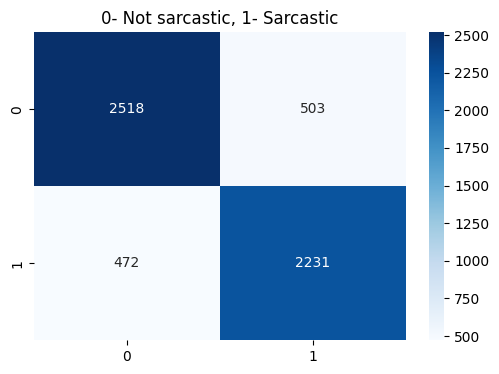

In [23]:
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title("0- Not sarcastic, 1- Sarcastic")
plt.show()

In [24]:
#for better results train for more epochs or use bigger BERT models(L=12 or 24)


print(classification_report(Y_pred,Y_test))

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84      3021
         1.0       0.82      0.83      0.82      2703

    accuracy                           0.83      5724
   macro avg       0.83      0.83      0.83      5724
weighted avg       0.83      0.83      0.83      5724



# Step 7: Random Predictions on unseen data

In [25]:
def predict_on_texts(text):
    pred=model.predict(text)[0][0]
    if(pred>0.5):
        result="Sarcastic"
    else:
        result="Not sarcastic"
    return result

In [26]:
text=["a man killed his neighbour because of some minor dispute"]
predict_on_texts(text)

1/1 [==============================] - 0s 457ms/step


'Not sarcastic'

In [27]:
text=["Dog becomes president of a country"]
predict_on_texts(text)

1/1 [==============================] - 0s 185ms/step


'Sarcastic'

In [29]:
text=["Car accident occurred due to drunk driving"]
predict_on_texts(text)

1/1 [==============================] - 0s 161ms/step


'Not sarcastic'

In [51]:
text=["monkey becomes president of a country"]
predict_on_texts(text)

1/1 [==============================] - 0s 145ms/step


'Sarcastic'

In [50]:
Input_data=input("Enter the input:")
prediction=predict_on_texts([Input_data])
print("Enter your comment:",Input_data)
print("Predicted sentiment is:",prediction)

1/1 [==============================] - 0s 138ms/step
Enter your comment: He looks like donkey
Predicted sentiment is: Sarcastic


# I'd say it's performing pretty well even on unseen data!

# Upvote if you found this useful!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5f83980f-250b-49be-9c90-886a2cee39ce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>